In this notebook I want to play with image manipulation I'm going to implement a blurring function on an input image.

One fundamental concept in computational photography: iterate over the output to generate the appropriate input to use. The reason for this is that when you iterate over the output, you can compute which pixels from the input image(s) are used to compute the output. This ensures that every pixel in the output will be assigned a value.

So, to blur an image:

1. Generate a kernel
2. Allocate a new image (blurring can't be an in-place operation because an input pixel is used multiple times, so can't be overwritten)
3. Iterate over the output, compute the input section used for that output, and convolve each input section with the kernel.

I am also curious to see the effects of different methods on the timing of the entire program.

In [245]:
using Images, TestImages, Colors, FileIO;

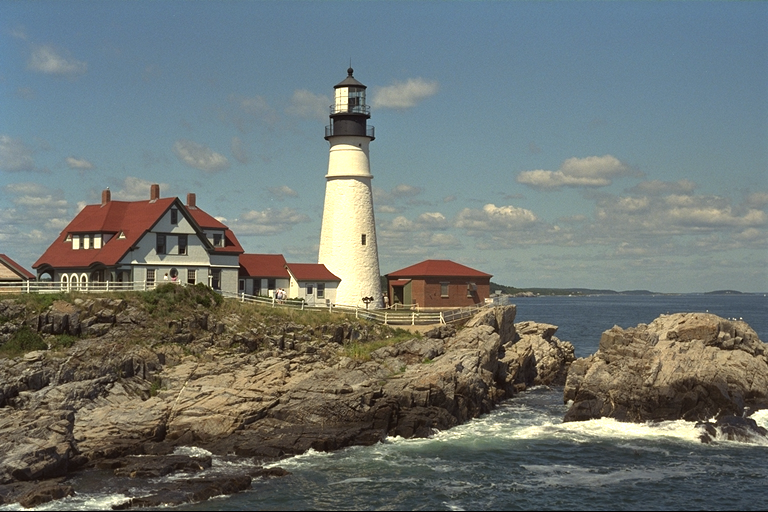

In [246]:
img = testimage("lighthouse")

## Generating kernels

I want to generate a few custom types (like structs in C++ or enum types in Python 3) to make data manipulation a little bit easier.

I tried to make a type called `size`, but got this error message (I took a screenshot because I didn't actually want to overwrite a new method called size). It looks like there is another method defined in the images packages - actually MANY of them! No matter, I will define a new type with a different name!

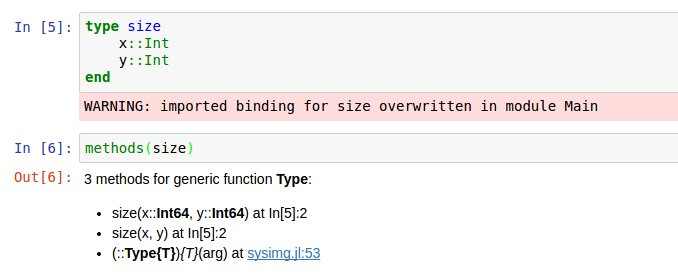

In [3]:
load("03-overwrite-main.jpg")

In [4]:
length(methods(size))

111

In [5]:
type coord
    x::Int
    y::Int
end

In [6]:
methods(coord)

# 3 methods for generic function "(::Type)":
coord(x::Int64, y::Int64) at In[5]:2
coord(x, y) at In[5]:2
(::Type{T}){T}(arg) at sysimg.jl:53

An interesting feature of Julia types is that they define default function constructors for a type, hence the output of the `methods` function above.

In the process of creating a function to generate a kernel in 2 dimensions, I want to generate a 1D gaussian. I can do this with an anonymous function. Even cooler, variable names in Julia can be represented as unicode! As [a friend](http://robindeits.com) says, "it can lead you to do some really awesome things, and some things you probably should not do." I think using LaTeX symbols in the Julia REPL is quite magical. Certainly easier to represent math!

(To generate unicode as a variable name, type `\` followed by the appropriate LaTeX symbol and press tab.)

In [7]:
# interestingly, pi is an internal constant!
# and you can even use LaTeX to represent it
println(pi)
println(π)
println(e)

π = 3.1415926535897...
π = 3.1415926535897...
e = 2.7182818284590...


The function name is `\phi`. This is the Gaussian function centered at 0, and you specify an input value `x` and a standard deviation `\sigma`.

In [8]:
ϕ(x, σ) = e^(-x^2 / (2 * σ^2)) / (σ * sqrt(2 * π))

ϕ (generic function with 1 method)

The fact that I can use the Julia dot notation and have it broadcast the function appropriately is magical!

In [9]:
# generate a 1D gaussian kernel
ϕ.(-3:3, 4)

7-element Array{Float64,1}:
 0.0752844
 0.0880163
 0.096667 
 0.0997356
 0.096667 
 0.0880163
 0.0752844

My coordinate type is initialized as an Int, but I want it to do something even better: I want to, when initializing a coordinate, if it is initialized as a float, have the coordinates rounded and turned into an `Int`. I can take advantage of the fact that types define constructors by adding a default constructor inside the type definition.

In [11]:
type coord
    x::Int
    y::Int
    coord(x, y) = new(Int(round(x)), Int(round(y)))
end

In [12]:
methods(coord)

# 3 methods for generic function "(::Type)":
coord(x::Int64, y::Int64) at In[5]:2
coord(x, y) at In[11]:4
(::Type{T}){T}(arg) at sysimg.jl:53

In [13]:
# you can see that it works!
coord(2.0, 2.0)

coord(2,2)

In [14]:
function generate_gaussian_kernel(σ=3.0, kernel_size=coord(3, 3))
    # because of the magic of functions and types, this just works!
    center = coord(kernel_size.x / 2, kernel_size.y / 2);
    kernel = Array{Float64}(kernel_size.x, kernel_size.y);
    for x in 1:kernel_size.x
        for y in 1:kernel_size.y
            distance_to_center = sqrt((center.x - x)^2 + (center.y - y)^2);
            kernel[x, y] = ϕ(distance_to_center, σ);
        end
    end
    # normalize the coefficients at the end
    # so the sum is 1
    kernel /= sum(kernel);
    # and assert it
    @assert sum(kernel) - 1 < 1e-5;
    # explicitly return a kernel
    return kernel;
end

generate_gaussian_kernel (generic function with 3 methods)

In [15]:
generate_gaussian_kernel(1, coord(3, 3))

3×3 Array{Float64,2}:
 0.0751136  0.123841  0.0751136
 0.123841   0.20418   0.123841 
 0.0751136  0.123841  0.0751136

## Putting it all together: blurring
Now let's put it all together to generate a blurred version of the image using our kernels!

The first thing you need to do is make sure your input image is floats, so you can do proper arithmetic. After much Googling I found that you need to use the `convert` function from Images.jl. Alternatively, you can use casting.

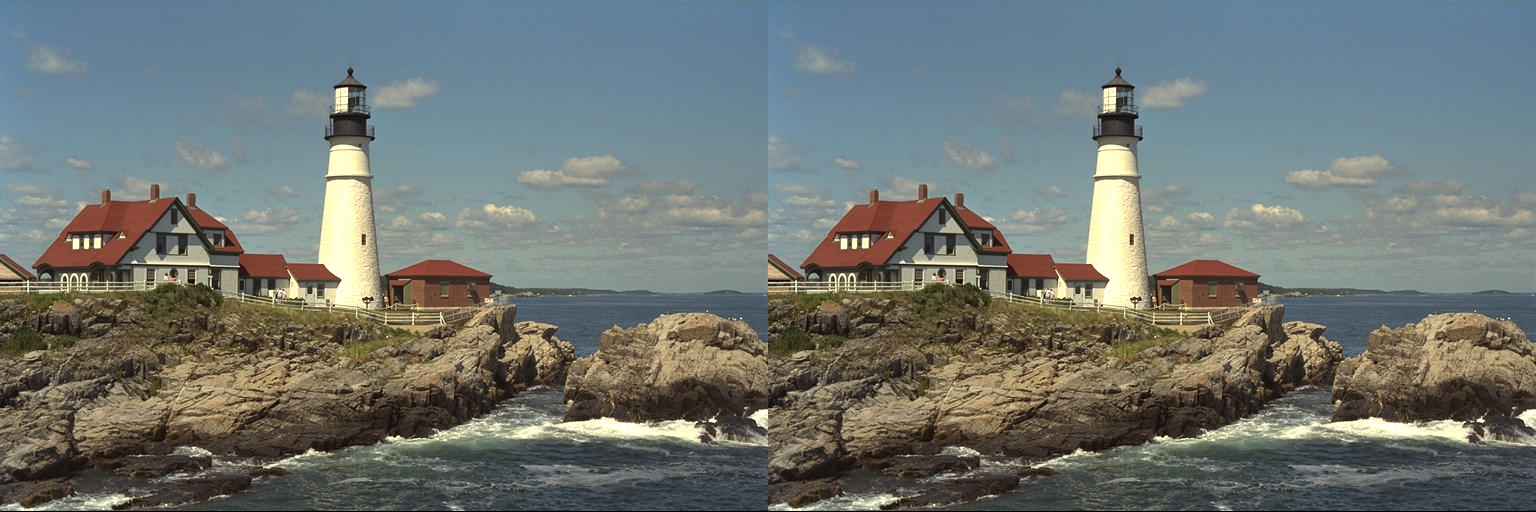

In [16]:
[convert(Array{RGB{Float64}}, img) RGB{Float64}.(img)]

In [312]:
function blur(img; kernel_size=15)
    # explicitly allocate an array of zeroes, to avoid
    # reading random memory, and ensuring the output
    # image starts out black
    img_blurred = zeros(RGB{Float64}, size(img, 1), size(img, 2));
    kernel = generate_gaussian_kernel(1, coord(kernel_size, kernel_size));
    for x in 1:size(img_blurred, 1) - kernel_size
        for y in 1:size(img_blurred, 2) - kernel_size
            # convolve the kernel with the image segment.
            # the .* operator is element-wise multiplication
            # as opposed to the * operator that is
            # matrix multiplication
            img_blurred[x, y] = sum(RGB{Float64}.(
                @view img[x:x+kernel_size-1, y:y+kernel_size-1]) .* kernel)
        end
    end
    return img_blurred;
end

blur (generic function with 1 method)

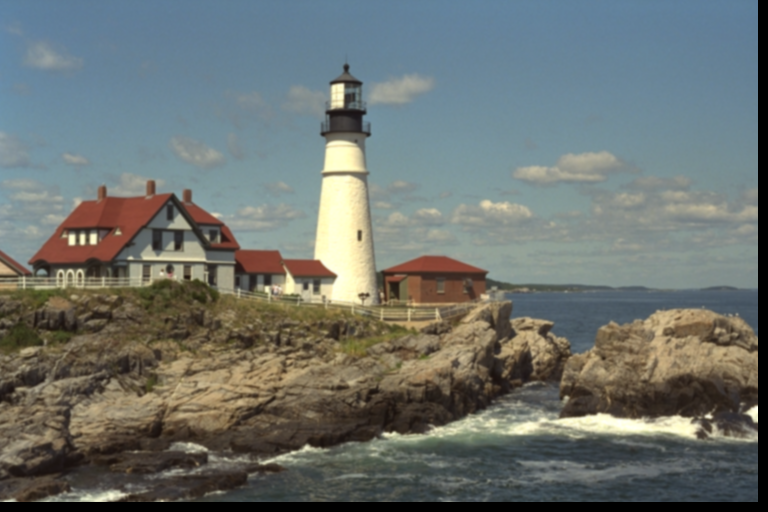

In [277]:
img_blurred = blur(img)

## Interpolating nearest neighbors with the Interpolations package

The black pixels on the edges of the image don't have exactly kernel-size matches in the input image, so for now I am just not not computing those pixels. The way I do this is by modifying the `for` loop to not iterate over the last pixels. The right way to fix this is to implement an "out of bounds" function to access pixels outside the range of an image.

In fact, the Julia [Interpolations.jl](https://github.com/tlycken/Interpolations.jl) package already implemented this!

In [234]:
# Pkg.add("Interpolations");

In [19]:
using Interpolations;

You can set an extrapolation object on an interpolation object.

In [20]:
?extrapolate

search: extrapolate AbstractExtrapolation



`extrapolate(itp, scheme)` adds extrapolation behavior to an interpolation object, according to the provided scheme.

The scheme can take any of these values:

  * `Throw` - throws a BoundsError for out-of-bounds indices
  * `Flat` - for constant extrapolation, taking the closest in-bounds value
  * `Linear` - linear extrapolation (the wrapped interpolation object must support gradient)
  * `Reflect` - reflecting extrapolation (indices must support `mod`)
  * `Periodic` - periodic extrapolation (indices must support `mod`)

You can also combine schemes in tuples. For example, the scheme `(Linear(), Flat())` will use linear extrapolation in the first dimension, and constant in the second.

Finally, you can specify different extrapolation behavior in different direction. `((Linear(),Flat()), Flat())` will extrapolate linearly in the first dimension if the index is too small, but use constant etrapolation if it is too large, and always use constant extrapolation in the second dimension.

`extrapolate(itp, fillvalue)` creates an extrapolation object that returns the `fillvalue` any time the indexes in `itp[x1,x2,...]` are out-of-bounds.


In [21]:
# here I am using Constant interpolation and Constant
# (for some reason called Flat) extrapolation
# a.k.a. Nearest Neighbor interpolation
img_interp = extrapolate(interpolate(img, BSpline(Constant()), OnGrid()), Flat());

In [278]:
function blur_nn(img; kernel_size=15)
    img_blurred = zeros(RGB{Float64}, size(img, 1), size(img, 2));
    kernel = generate_gaussian_kernel(1, coord(kernel_size, kernel_size));
    for x in 1:size(img_blurred, 1)
        for y in 1:size(img_blurred, 2)
            # convolve the kernel with the image segment.
            # the .* operator is element-wise multiplication
            # as opposed to the * operator that is
            # matrix multiplication
            img_blurred[x, y] = sum(RGB{Float64}.(
                img_interp[x:x+kernel_size-1, y:y+kernel_size-1]) .* kernel)
        end
    end
    return img_blurred;
end

blur_nn (generic function with 1 method)

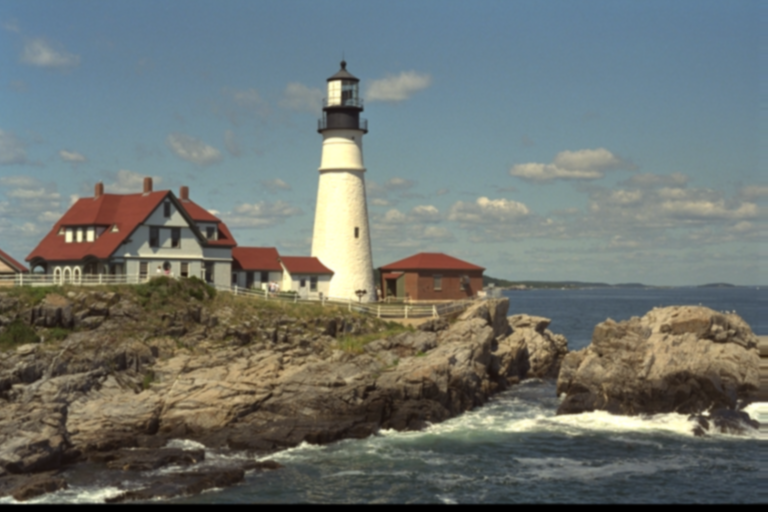

In [279]:
img_blurred = blur_nn(img)

Interestingly enough, the last few rows in the blurred image are black. The reason for this that if you look at the last rows in the original image, it is a fully-black row:

In [280]:
img[end, :]

The previous-to-last row is not black. The original image from the TestImages package just has a row of black pixels for some reason.

In [281]:
img[end - 1, :]

## Creating a custom implementation of mirror interpolation

We can get rid of those artifacts by using a "mirror" interpolation. Every time you try to access a pixel outside the range, you take that index inside the range. I am going to overload the index operation to mirror the index into the image. But, I don't want to overload the `[]` operator on every array - instead, I'm going to create a new `InterpImage` type, and add overload the `getindex` operator on the `InterpImage` type.

In [282]:
type InterpImage
    img::Array;
end

And while I'm here, I'll just make an `InterpImage` with my original image.

In [283]:
iimg = InterpImage(img);

To overload the `getindex` function, you need import `Base.getindex` explicitly. If you don't, the Julia REPL will tell you to do so.

In [284]:
import Base.getindex;

And as a warning, my mod-multiply-add arithmetic to compute the ranges is a little crazy, but it makes this a one-liner!

In [313]:
function getindex(im::InterpImage, xrange::UnitRange, yrange::UnitRange)
    # we take advantage of all the optimization already done on
    # UnitRanges. instead, we construct a new set of ranges and
    # use a single call to getindex on an image with those ranges
    max_x = size(img, 1);
    max_y = size(img, 2);
    new_xrange = Int.([
            ((floor(abs(x) / max_x) + 1) % 2) * 
            ((abs(x) % (max_x)) + 1) + 
            (floor(abs(x) / max_x) % 2) * 
            (max_x - (abs(x) % (max_x))) for x in xrange]);
    new_yrange = Int.([
            ((floor(abs(x) / max_y) + 1) % 2) *
            ((abs(x) % (max_y)) + 1) + 
            (floor(abs(x) / max_y) % 2) * 
            (max_y - (abs(x) % (max_y))) for x in yrange]);
    return im.img[new_xrange, new_yrange];
end

getindex (generic function with 315 methods)

And as a result, I can mirror-index into my interpolated image. Even with negative indices! Trippy. I call this one, _Lighthouseption_.

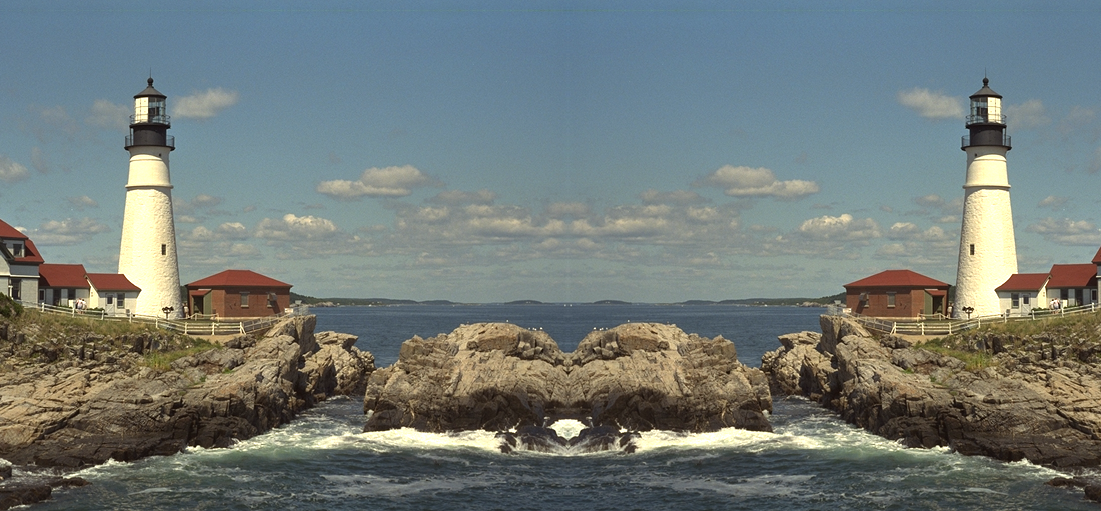

In [314]:
iimg[-10:500, 200:1300]

And this one, _Lighthouse In The Sky_.

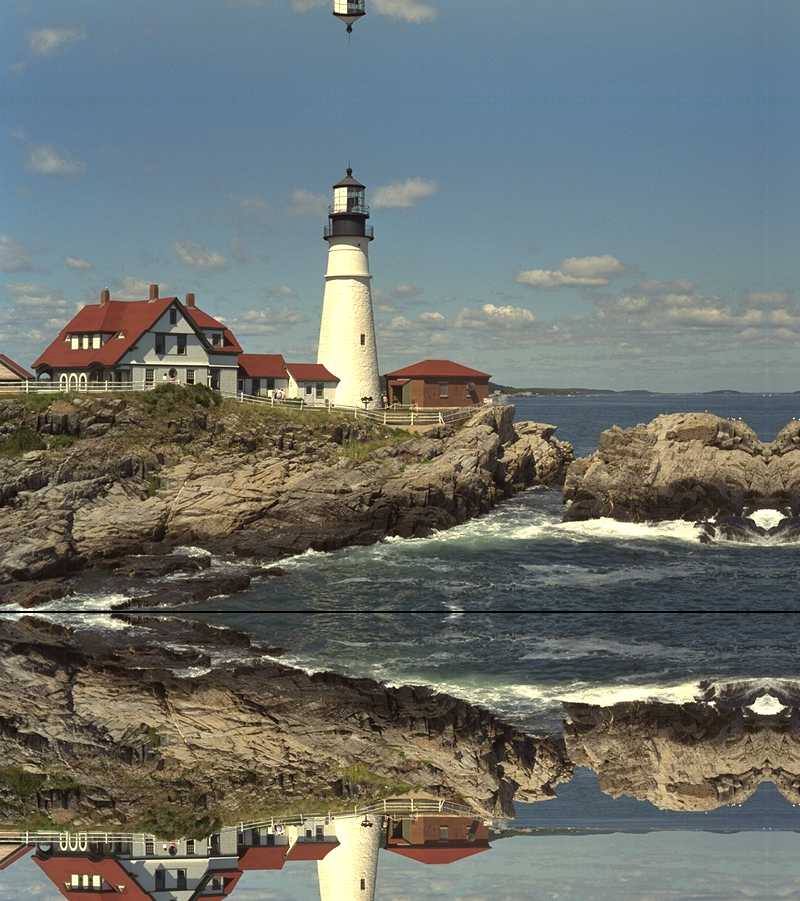

In [289]:
iimg[-100:800, 1:800]

And now we can update our previous blur function to use the mirrored interpolation, if it tries to access a pixel outside the range. The black line at the bottom of the image should go away.

In [292]:
function blur_mirror(img; kernel_size=15)
    img_blurred = zeros(RGB{Float64}, size(img, 1), size(img, 2));
    iimg = InterpImage(img);
    kernel = generate_gaussian_kernel(1, coord(kernel_size, kernel_size));
    for x in 1:size(img_blurred, 1)
        for y in 1:size(img_blurred, 2)
            # convolve the kernel with the image segment.
            # the .* operator is element-wise multiplication
            # as opposed to the * operator that is
            # matrix multiplication
            img_blurred[x, y] = sum(RGB{Float64}.(
                iimg[x:x+kernel_size-1, y:y+kernel_size-1]) .* kernel)
        end
    end
    return img_blurred;
end

blur_mirror (generic function with 1 method)

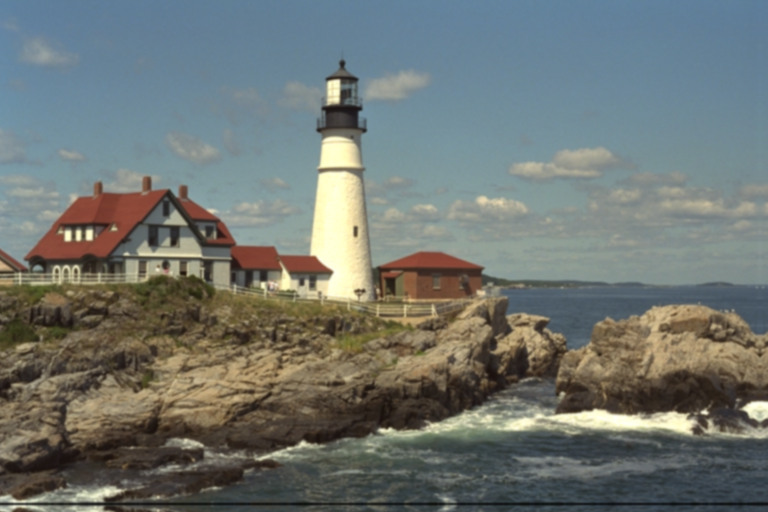

In [293]:
img_blurred = blur_mirror(img)

And so it does!
The problem with this implementation (that I can't really do anything about, short of writing optimized for loop code), is that because I am not using `UnitRange` types to access the subsets of the image for my kernel calculations, it is slower than the previous blur implementations. For comparison, all the functions running with kernel size 15:

In [309]:
@elapsed img_blurred = blur(img, 15)

1.454406513

In [310]:
@elapsed img_blurred = blur_nn(img, 15)

3.663044043

In [311]:
@elapsed img_blurred = blur_mirror(img, 15)

22.964779733

Oh well. I don't know why the mirror code is so much slower than the interpolation code, given that to construct my index range all I am doing is some arithmetic operations, which can't be that much different than the interpolation code. That exploration is for another time.

## An aside on broadcasting linear interpolations

I wanted to broadcast linear interpolations on two input ranges, which didn't work using the construct above. First I created an interpolate / extrapolate object with linear interpolation in both.

In [ ]:
img_interp = extrapolate(interpolate(img, BSpline(Linear()), OnGrid()), Linear());

And Robin showed me how to turn a function call into an index broadcast. I am still wrapping my head around what this means. But basically, the object `img_interp`, when called as a function with any `args...`, broadcast those arguments into indexing notation. So when `img_interp` is called with range arguments like `1:10`, it calls each element in the range into index notation. I had to adjust my blurring code to call `img_interp` as a function, but it works! The right edge of the image looks different than a blur using nearest neighbor interpolation above.

In [351]:
(img_interp::typeof(img_interp))(args...) = img_interp[args...]

In [362]:
img_blurred = Array{RGB{Float64}}(size(img))
kernel_size = 15;
kernel = generate_gaussian_kernel(1, coord(kernel_size, kernel_size));
for x in 1:size(img_blurred, 1)
    for y in 1:size(img_blurred, 2)
        # convolve the kernel with the image segment.
        # the .* operator is element-wise multiplication
        # as opposed to the * operator that is
        # matrix multiplication
        img_blurred[x, y] = sum(RGB{Float64}.(
            img_interp.(x:x+kernel_size-1, (y:y+kernel_size-1))') .* kernel)
    end
end

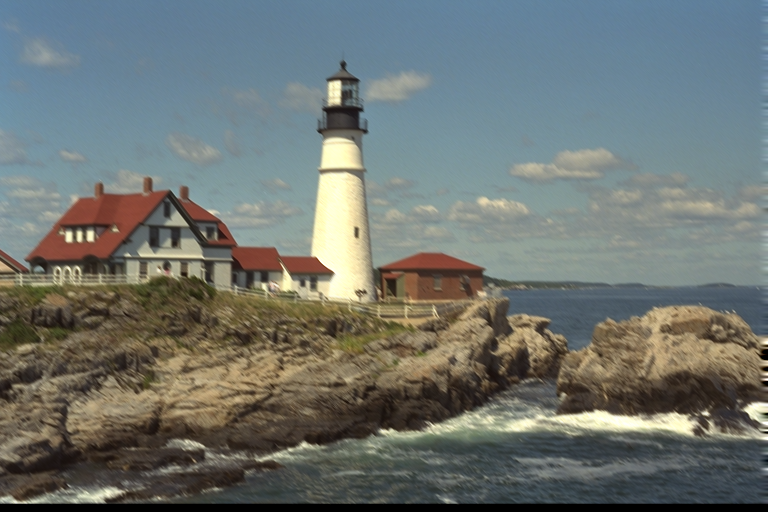

In [363]:
img_blurred